# PART II: Correlation Analysis

- Gabriel Wendell Celestino Rocha
- Alberto Bezerra de Palhares Júnior
- Joab Morais Varela
- Rafael Chaves Souto Araújo

---

## 0. Setup

In [1]:
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec
from matplotlib.font_manager import FontProperties
from matplotlib.collections import PolyCollection, LineCollection

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

import seaborn as sns
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

- ### Aesthetic functions

In [2]:
%matplotlib inline

cm_font = FontProperties(fname  = 'CutiveMono-Regular.ttf')
gs_font = FontProperties(fname  = 'GillSans-Light.otf')
cm_size = 20



def sm_plot(grid = True, font = cm_font, font_size = 15):
    # plt.style.use('dark_background')
    plt.grid(grid, linestyle = ':', color = '0.50')
    # plt.rcParams['text.usetex'] = True
    plt.rcParams['font.family'] = 'monospace'
    plt.rcParams['font.size'] = font_size
    plt.minorticks_on()
    plt.tick_params(axis = 'both', which = 'minor', direction = "in",
                        top = True, right = True, length = 5, width = 1, labelsize = 15)
    plt.tick_params(axis = 'both', which = 'major', direction = "in",
                        top = True, right = True, length = 8, width = 1, labelsize = 15)
    
    
    
def sm_plot_mod(ax, grid = True, font = cm_font, font_size = 15):
    # plt.style.use('dark_background')
    ax.grid(True, linestyle = ':', color = '0.50')
    plt.rcParams['font.family'] = 'monospace'
    plt.rcParams['font.size'] = font_size
    ax.minorticks_on()
    ax.tick_params(axis = 'both', which = 'minor', direction = "in",
                        top = True,right = True, length = 5,width = 1, labelsize = 15)
    ax.tick_params(axis = 'both', which = 'major', direction = "in",
                        top = True, right = True, length = 8,width = 1, labelsize = 15)

---

## 1. Reading the Data

Reading river station, river-dam station and weather station data:

- **River station:** Kluserbrücke 
- **Weather station:** Wuppertal-Buchenhofen 
- **River-damn station:** Wupper-Talsperre 

- `data_reduced.csv`: Dataframe with all data from 1990 to 2023
- `data_reduced_weekly.csv`: Dataframe with data reduced according to a weekly average
- `data_reduced_monthly.csv`: Dataframe with data reduced according to a monthly average

In [12]:
df = pd.read_csv('Reduced_Data/data_reduced.csv', sep = ',')
df_weekly = pd.read_csv('Reduced_Data/data_reduced_weekly.csv', sep = ',')
df_monthly = pd.read_csv('Reduced_Data/data_reduced_monthly.csv', sep = ',')

# -------------------------------------------------------------------------------------------------

print('River station: Kluserbrücke')
print('Weather station: Wuppertal-Buchenhofen')
print('River-damn station: Wupper-Talsperre')

print('')

print('1) All Data (1990 - 2024):', df.shape)
print('2) Weekly Average:', df_weekly.shape)
print('3) Monthly Average:', df_monthly.shape)

River station: Kluserbrücke
Weather station: Wuppertal-Buchenhofen
River-damn station: Wupper-Talsperre

1) All Data (1990 - 2024): (12062, 12)
2) Weekly Average: (1774, 12)
3) Monthly Average: (12828, 13)


## 2. Scatterplot Matrix

- **Dataframe with the variables to be analyzed**

,WATER-LEVEL,DISCHARGE,RS,RSF,PIVOT
0,4.548,22.0,0.1,6.0,1
1,4.548,22.0,0.0,0.0,3
2,4.548,22.0,0.0,6.0,4
3,3.799,20.0,0.0,0.0,6
4,3.799,20.0,0.0,0.0,7
...,...,...,...,...,...
12057,77.293,172.9,2.8,4.0,12414
12058,70.436,161.4,0.3,4.0,12415
12059,66.657,154.9,17.6,4.0,12416
12060,60.286,143.7,0.1,4.0,12417


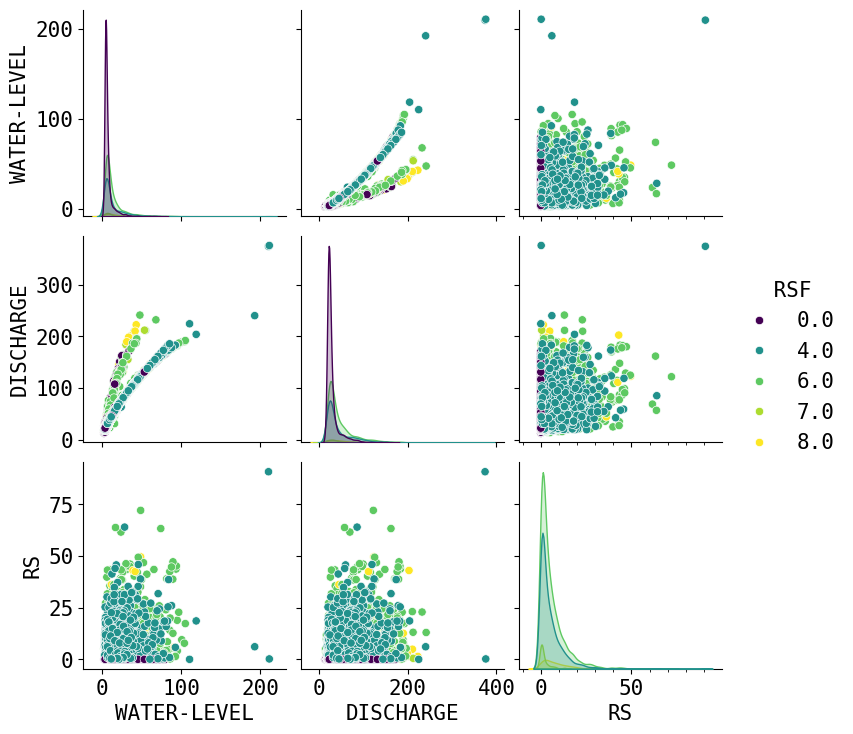

In [20]:
df = df.rename(columns = {'  RS': 'RS'})
cols_to_remove = ['MESS_DATUM', 'RS1', 'RS2', 'RS3', 'RS7', 'RS14', 'FLOOD']
df_reduced = df.drop(columns = cols_to_remove)
df_reduced = df_reduced[df_reduced[' RSF'] >= 0]
display(df_reduced)


# -------------------------------------------------------------------------------------------------


sns.pairplot(df_reduced, hue = ' RSF', palette = 'viridisz',
             x_vars = ['WATER-LEVEL', 'DISCHARGE', 'RS'], y_vars = ['WATER-LEVEL', 'DISCHARGE', 'RS'])
sm_plot()

---

## 2. Autocorrelation, Partial Autocorrelation $\&$ Discrete Autocorrelation

- ### Discretization of Time Series

In [22]:
wl_diff = np.diff(df['WATER-LEVEL'], n = 2)
wl_diff_weekly = np.diff(df_weekly['WATER-LEVEL'], n = 2)
wl_diff_monthly = np.diff(df_monthly['WATER-LEVEL'], n = 2)

dis_diff = np.diff(df['DISCHARGE'], n = 2)
dis_diff_weekly = np.diff(df_weekly['DISCHARGE'], n = 2)
dis_diff_monthly = np.diff(df_monthly['DISCHARGE'], n = 2)


# -------------------------------------------------------------------------------------------------


acf_wl_diff = acf(wl_diff, nlags = nlags)
acf_wl_diff_weekly = acf(wl_diff_weekly, nlags = nlags)
acf_wl_diff_monthly = acf(wl_diff_monthly, nlags = nlags)

acf_dis_diff = acf(dis_diff, nlags = nlags)
acf_dis_diff_weekly = acf(dis_diff_weekly, nlags = nlags)
acf_dis_diff_monthly = acf(dis_diff_monthly, nlags = nlags)

- ### **Number of lags and calculations**

In [23]:
# Number of lags
nlags = 50
n = len(df['WATER-LEVEL'])
lags_sturges = int(np.log2(n) + 1)


# -------------------------------------------------------------------------------------------------


# ACF Calculation 
acf_wl = acf(df['WATER-LEVEL'], nlags = nlags)
acf_wl_weekly = acf(df_weekly['WATER-LEVEL'], nlags = nlags)
acf_wl_monthly = acf(df_monthly['WATER-LEVEL'], nlags = nlags)
acf_wl_diff = acf(wl_diff, nlags = nlags)

acf_dis = acf(df['DISCHARGE'], nlags = nlags)
acf_dis_weekly = acf(df_weekly['DISCHARGE'], nlags = nlags)
acf_dis_monthly = acf(df_monthly['DISCHARGE'], nlags = nlags)
acf_dis_diff = acf(dis_diff, nlags = nlags)


# PACF Calculation
pacf_wl = pacf(df['WATER-LEVEL'], nlags = nlags)
pacf_wl_weekly = pacf(df_weekly['WATER-LEVEL'], nlags = nlags)
pacf_wl_monthly = pacf(df_monthly['WATER-LEVEL'], nlags = nlags)

pacf_dis = pacf(df['DISCHARGE'], nlags = nlags)
pacf_dis_weekly = pacf(df_weekly['DISCHARGE'], nlags = nlags)
pacf_dis_monthly = pacf(df_monthly['DISCHARGE'], nlags = nlags)

- ### Bartett's Formula Confidence Intervals

$$
\chi^{2}=\frac{\left(N-k\right)\ln\left(S_{p}^{2}\right)-\sum_{i=1}^{k}\left(n_{i}-1\right)\ln\left(S_{i}^{2}\right)}{1+\frac{1}{3\left(k-1\right)}\left[\sum_{i=1}^{p}\left(n_{i}-1\right)^{-1}-\left(N-k\right)^{-1}\right]}\quad,\quad\begin{cases}
N=\sum_{i=1}^{k}n_{i} & ,\\
S_{p}^{2}=\frac{1}{N-k}\sum_{i}\left(n_{i}-1\right)S_{i}^{2} & .
\end{cases}
$$

In [24]:
def bartlett_confidence_intervals(acf_values, num_samples, confidence_level = 0.95):
    z = 1.96  # For a 95% confidence interval
    lags = np.arange(len(acf_values))
    # Initialize the list of standard deviations
    standard_errors = np.zeros(len(acf_values))
    
    # Calculate the standard deviation for each lag using Bartlett's formula
    for k in lags:
        if k == 0:
            standard_errors[k] = 0  # ACF at lag 0 is 1, there is no standard deviation associated
        else:
            standard_errors[k] = np.sqrt((1 + 2 * np.sum(acf_values[:k] ** 2)) / num_samples)
    
    # Calculate the confidence interval
    confidence_intervals = z * standard_errors
    
    return confidence_intervals

- ### Confidence Interval for ACF, PACF $\&$ DACF

In [25]:
# ACF 
ci_wl_acf = bartlett_confidence_intervals(acf_wl, n)
ci_wl_acf_weekly = bartlett_confidence_intervals(acf_wl_weekly, n)
ci_wl_acf_monthly = bartlett_confidence_intervals(acf_wl_monthly, n)

ci_dis_acf = bartlett_confidence_intervals(acf_dis, n)
ci_dis_acf_weekly = bartlett_confidence_intervals(acf_dis_weekly, n)
ci_dis_acf_monthly = bartlett_confidence_intervals(acf_dis_monthly, n)


# -------------------------------------------------------------------------------------------------


# PACF
ci_wl_pacf = bartlett_confidence_intervals(pacf_wl, n)
ci_wl_pacf_weekly = bartlett_confidence_intervals(pacf_wl_weekly, n)
ci_wl_pacf_monthly = bartlett_confidence_intervals(pacf_wl_monthly, n)

ci_dis_pacf = bartlett_confidence_intervals(pacf_dis, n)
ci_dis_pacf_weekly = bartlett_confidence_intervals(pacf_dis_weekly, n)
ci_dis_pacf_monthly = bartlett_confidence_intervals(pacf_dis_monthly, n)


# -------------------------------------------------------------------------------------------------


# DACF
ci_wl_diff_acf = bartlett_confidence_intervals(acf_wl_diff, n)
ci_wl_diff_acf_weekly = bartlett_confidence_intervals(acf_wl_diff_weekly, n)
ci_wl_diff_acf_monthly = bartlett_confidence_intervals(acf_wl_diff_monthly, n)

ci_dis_diff = bartlett_confidence_intervals(acf_dis_diff, n)
ci_dis_diff_acf_weekly = bartlett_confidence_intervals(acf_dis_diff_weekly, n)
ci_dis_diff_acf_monthly = bartlett_confidence_intervals(acf_dis_diff_monthly, n)

- ### Plots: ACF, PACF $\&$ DACF

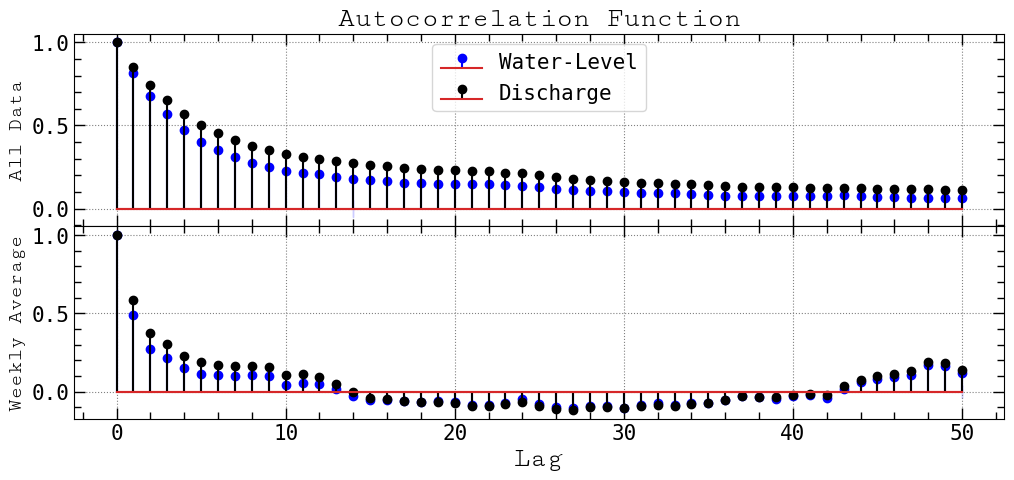

In [43]:
fig = plt.figure(figsize = (12,5))
fig.subplots_adjust(hspace = 0)
spec = gridspec.GridSpec(ncols = 1, nrows = 2, figure = fig)

ax0 = fig.add_subplot(spec[0, 0])
ax1 = fig.add_subplot(spec[1, 0])
#ax2 = fig.add_subplot(spec[2, 0])

ax0.stem(range(50 + 1), acf_wl, 'b', label = 'Water-Level')
ax0.stem(range(50 + 1), acf_dis, 'k', label = 'Discharge')

ax1.stem(range(50 + 1), acf_wl_weekly, 'b', label = 'Water-Level')
ax1.stem(range(50 + 1), acf_dis_weekly, 'k', label = 'Discharge')

#ax2.stem(range(50 + 1), acf_wl_monthly, 'b', label = 'Water-Level')
#ax2.stem(range(50 + 1), acf_dis_monthly, 'k', label = 'Discharge')


ax0.fill_between(lags_sturges, ci_wl_acf, -ci_wl_acf, color = 'b', alpha = 0.2)
ax1.fill_between(nlags, ci_dis_acf_weekly, -ci_dis_acf_weekly, color = 'b', alpha = 0.2)
#ax2.fill_between(nlags, ci_dis_acf_monthly, -ci_dis_acf_monthly, color = 'b', alpha = 0.2)

ax0.set_title('Autocorrelation Function', fontproperties = cm_font, fontsize = cm_size)
ax0.set_ylabel('All Data', fontproperties = cm_font, fontsize = 15)
ax1.set_ylabel('Weekly Average', fontproperties = cm_font, fontsize = 15)
#ax2.set_ylabel('Monthly Average', fontproperties = cm_font, fontsize = 15)

ax1.set_xlabel('Lag', fontproperties = cm_font, fontsize = cm_size)


sm_plot_mod(ax0)
sm_plot_mod(ax1)
#sm_plot_mod(ax2)
ax0.legend(loc = 9)

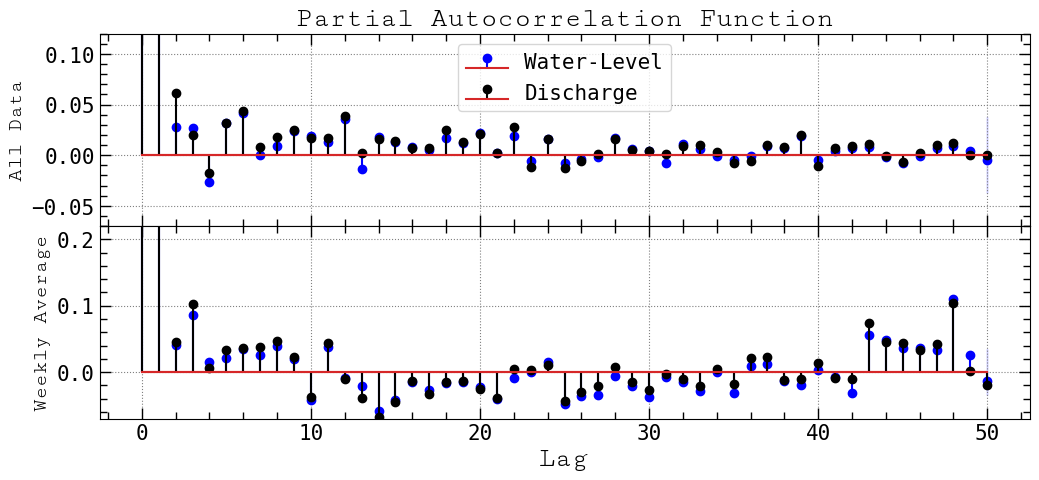

In [41]:
fig = plt.figure(figsize = (12,5))
fig.subplots_adjust(hspace = 0)
spec = gridspec.GridSpec(ncols = 1, nrows = 2, figure = fig)

ax0 = fig.add_subplot(spec[0, 0])
ax1 = fig.add_subplot(spec[1, 0])
#ax2 = fig.add_subplot(spec[2, 0])

ax0.stem(range(50 + 1), pacf_wl, 'b', label = 'Water-Level')
ax0.stem(range(50 + 1), pacf_dis, 'k', label = 'Discharge')

ax1.stem(range(50 + 1), pacf_wl_weekly, 'b', label = 'Water-Level')
ax1.stem(range(50 + 1), pacf_dis_weekly, 'k', label = 'Discharge')

#ax2.stem(range(50 + 1), pacf_wl_monthly, 'b', label = 'Water-Level')
#ax2.stem(range(50 + 1), pacf_dis_monthly, 'k', label = 'Discharge')


ax0.fill_between(nlags, ci_wl_pacf, -ci_wl_pacf, color = 'b', alpha = 0.2)
ax1.fill_between(nlags, ci_dis_pacf_weekly, -ci_dis_pacf_weekly, color = 'b', alpha = 0.2)
#ax2.fill_between(lags, ci_dis_pacf_monthly, -ci_dis_pacf_monthly, color = 'b', alpha = 0.2)

ax0.set_title('Partial Autocorrelation Function', fontproperties = cm_font, fontsize = cm_size)
ax0.set_ylabel('All Data', fontproperties = cm_font, fontsize = 15)
ax1.set_ylabel('Weekly Average', fontproperties = cm_font, fontsize = 15)
#ax2.set_ylabel('Monthly Average', fontproperties = cm_font, fontsize = 15)
ax1.set_xlabel('Lag', fontproperties = cm_font, fontsize = cm_size)


ax0.set_ylim(-0.07,0.12)
ax1.set_ylim(-0.07,0.22)
#ax2.set_ylim(-0.12,0.32)


sm_plot_mod(ax0)
sm_plot_mod(ax1)
#sm_plot_mod(ax2)
ax0.legend(loc = 9)

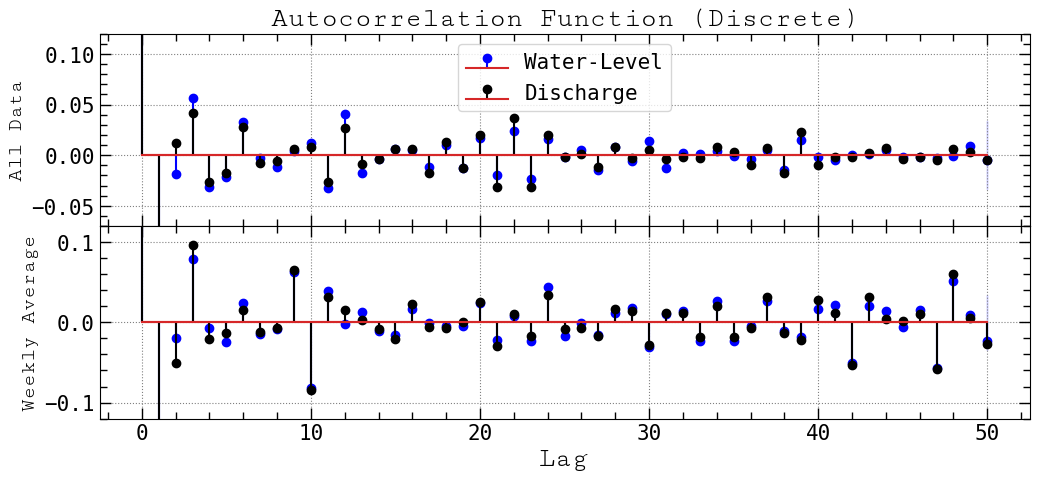

In [42]:
fig = plt.figure(figsize = (12,5))
fig.subplots_adjust(hspace = 0)
spec = gridspec.GridSpec(ncols = 1, nrows = 2, figure = fig)

ax0 = fig.add_subplot(spec[0, 0])
ax1 = fig.add_subplot(spec[1, 0])
#ax2 = fig.add_subplot(spec[2, 0])

ax0.stem(range(50 + 1), acf_wl_diff, 'b', label = 'Water-Level')
ax0.stem(range(50 + 1), acf_dis_diff, 'k', label = 'Discharge')

ax1.stem(range(50 + 1), acf_wl_diff_weekly, 'b', label = 'Water-Level')
ax1.stem(range(50 + 1), acf_dis_diff_weekly, 'k', label = 'Discharge')

#ax2.stem(range(50 + 1), acf_wl_diff_monthly, 'b', label = 'Water-Level')
#ax2.stem(range(50 + 1), acf_dis_diff_monthly, 'k', label = 'Discharge')


ax0.fill_between(nlags, ci_wl_diff_acf, -ci_wl_diff_acf, color = 'b', alpha = 0.2)
ax1.fill_between(nlags, ci_dis_diff_acf_weekly, -ci_dis_diff_acf_weekly, color = 'b', alpha = 0.2)
#ax2.fill_between(lags, ci_dis_diff_acf_monthly, -ci_dis_diff_acf_monthly, color = 'b', alpha = 0.2)

ax0.set_title('Autocorrelation Function (Discrete)', fontproperties = cm_font, fontsize = cm_size)
ax0.set_ylabel('All Data', fontproperties = cm_font, fontsize = 15)
ax1.set_ylabel('Weekly Average', fontproperties = cm_font, fontsize = 15)
#ax2.set_ylabel('Monthly Average', fontproperties = cm_font, fontsize = 15)
ax1.set_xlabel('Lag', fontproperties = cm_font, fontsize = cm_size)

ax0.set_ylim(-0.07,0.12)
ax1.set_ylim(-0.12,0.12)
#ax2.set_ylim(-0.20,0.22)


sm_plot_mod(ax0)
sm_plot_mod(ax1)
#sm_plot_mod(ax2)
ax0.legend(loc = 9)

---